In [ ]:
!pip install casadi

In [3]:
import casadi as ca
import numpy as np
from casadi import sin, cos, pi
import matplotlib.pyplot as plt
from matplotlib import animation

In [ ]:
# setting matrix_weights' variables
Q_x = 10
Q_y =10
Q_theta = 0.1
R1 =0.5
R2 =0.05
ROB_diameter=0.2

h= 0.1  # time between steps in seconds
N = 10          # number of look ahead steps
Tf = 100     # simulation time

##Obstacles
OBS=np.array([[-1.08,-1.08,0.6],[-1.08,0,0.6],[-1.08,1.08,0.6],[0,-1.08,0.6],[0,0,0.6],[0,1.08,0.6],\
        [1.08,-1.08,0.6],[1.08,0,0.6],[1.08,1.08,0.6]]) # x_center, y_center, diameter
n_obs=OBS.shape[0]

x_init =-2
y_init = -0.5
theta_init = 0
x_target =0.5
y_target =2
theta_target = 0

state_init = ca.DM([x_init, y_init, theta_init])        # initial state
state_target = ca.DM([x_target, y_target, theta_target])  # target state

v_max = 2
v_min = 0
w_min=-pi
w_max=pi

x=ca.SX.sym("x",3)
u=ca.SX.sym("u",2)
xdot=ca.vertcat(u[0]*cos(x[2]),u[0]*sin(x[2]),u[1])
f=ca.Function('f',[x,u],[xdot])
F=ca.simpleRK(f,Tf)

X = ca.SX.sym('X', 3, N + 1)

U = ca.SX.sym('U', 2, N)

P = ca.SX.sym('P',3 + 3)

Q = ca.diagcat(Q_x, Q_y, Q_theta)

R = ca.diagcat(R1, R2)



j = 0  # cost function
g = X[:, 0] - P[:3]  # constraints in the equation


for k in range(N):
    st = X[:, k]
    con = U[:, k]
    e=st-P[3:]
    j+=ca.mtimes(ca.mtimes(e.T,Q),e)+ca.mtimes(ca.mtimes(con.T,R),con)
    st_next = X[:, k+1]
    X_next=F(st,con,h)

    g = ca.vertcat(g, st_next -X_next)

## Add obstacles constraints
for obs in OBS:
 for k in range(N+1):
   st = X[:, k]
   g = ca.vertcat(g, -ca.sqrt((st[0]-obs[0])**2+(st[1]-obs[1])**2) + (ROB_diameter/2 + obs[2]/2));


OPT_variables = ca.vertcat(
    X.reshape((-1, 1)),   # Example: 3x11 ---> 33x1 where 3=states, 11=N+1
    U.reshape((-1, 1))
)
nlp_prob = {
    'f': j,
    'x': OPT_variables,
    'g': g,
    'p': P
}

opts = {
    'ipopt': {
        'max_iter': 2000,
        'print_level': 0,
        'acceptable_tol': 1e-8,
        'acceptable_obj_change_tol': 1e-6
    },
    'print_time': 0
}

solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

lbx = ca.DM.zeros((3*(N+1) + 2*N, 1))
ubx = ca.DM.zeros((3*(N+1) + 2*N, 1))

lbx[0: 3*(N+1): 3] = -ca.inf     # X lower bound
lbx[1:3*(N+1): 3] = -ca.inf     # Y lower bound
lbx[2: 3*(N+1): 3] = -ca.inf     # theta lower bound

ubx[0: 3*(N+1): 3] = ca.inf      # X upper bound
ubx[1: 3*(N+1): 3] = ca.inf      # Y upper bound
ubx[2: 3*(N+1): 3] = ca.inf      # theta upper bound

lbx[3*(N+1)::2] = v_min
lbx[3*(N+1)+1::2] = w_min
ubx[3*(N+1)::2] = v_max
ubx[3*(N+1)+1::2] = w_max

lbg=ca.DM.zeros(3*(N+1)+n_obs*(N+1), 1)
lbg[3*(N+1):3*(N+1)+n_obs*(N+1)]=-ca.inf
ubg=ca.DM.zeros(3*(N+1)+n_obs*(N+1), 1)

args = {
    'lbg': lbg,  # constraints lower bound
    'ubg': ubg,  # constraints upper bound
    'lbx': lbx,
    'ubx': ubx
}





u0 = ca.DM.zeros((2, N))  # initial control
X0 = ca.repmat(state_init, 1, N+1)         # initial state full


mpc_iter = 0


X_O=[]
U_o=[]

###############################################################################

if __name__ == '__main__':
    while (ca.norm_2(state_init - state_target) > 1e-1) and (mpc_iter * h < Tf):

        args['p'] = ca.vertcat(
            state_init,    # current state
            state_target   # target state
        )
        # optimization variable current state
        args['x0'] = ca.vertcat(
            ca.reshape(X0, 3*(N+1), 1),
            ca.reshape(u0, 2*N, 1)
        )

        sol = solver(
            x0=args['x0'],
            lbx=args['lbx'],
            ubx=args['ubx'],
            lbg=args['lbg'],
            ubg=args['ubg'],
            p=args['p']
        )

        u = ca.reshape(sol['x'][3 * (N + 1):], 2, N)
        X0 = ca.reshape(sol['x'][: 3 * (N+1)], 3, N+1)


        X_O.append(state_init)
        U_o.append(u[:,0])

        state_init=F(state_init,u[:,0],h)

        u0 = ca.horzcat(u[:, 1:],ca.reshape(u[:, -1], -1, 1))
        X0 = ca.horzcat(
            X0[:, 1:],
            ca.reshape(X0[:, -1], -1, 1)
        )
        print(mpc_iter)
        print("X=",state_init[0], "  Y=", state_init[1],"  theta=",state_init[2])
        mpc_iter = mpc_iter + 1
    ss_error = ca.norm_2(state_init - state_target)
    print("/n")
    print('final error: ', ss_error)


DM([0.505453, 1.97864, 0.0868559])

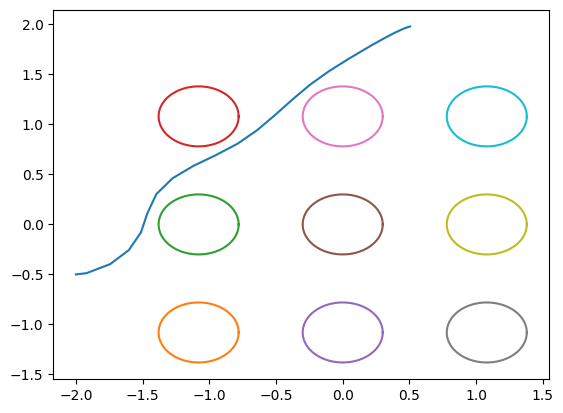

In [9]:
angle = np.linspace( 0 , 2 * np.pi , 150 )

radius = 0.3

x1 = radius * np.cos( angle )-1.08
y1 = radius * np.sin( angle )-1.08

x2 = radius * np.cos( angle )-1.08
y2 = radius * np.sin( angle )

x3 = radius * np.cos( angle )-1.08
y3 = radius * np.sin( angle )+1.08

x4 = radius * np.cos( angle )
y4 = radius * np.sin( angle )-1.08

x5 = radius * np.cos( angle )
y5 = radius * np.sin( angle )

x6 = radius * np.cos( angle )
y6 = radius * np.sin( angle )+1.08

x7 = radius * np.cos( angle )+1.08
y7 = radius * np.sin( angle )-1.08

x8 = radius * np.cos( angle )+1.08
y8 = radius * np.sin( angle )

x9 = radius * np.cos( angle )+1.08
y9 = radius * np.sin( angle )+1.08

X=np.array(X_O)[:,0]
Y=np.array(X_O)[:,1]
plt.plot(X,Y)
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x3,y3)
plt.plot(x4,y4)
plt.plot(x5,y5)
plt.plot(x6,y6)
plt.plot(x7,y7)
plt.plot(x8,y8)
plt.plot(x9,y9)
state_init